# Workflow

In [1]:
import matplotlib.pyplot as plt
from matplotlib.figure import figaspect
import numpy as np
import pandas as pd

import mammos_analysis
import mammos_dft
import mammos_spindynamics
import mammos_mumag
import mammos_entity as me
import mammos_units as u

u.set_enabled_equivalencies(u.magnetic_flux_field());

In [2]:
import warnings
warnings.filterwarnings("ignore")

## 1: DFT data: magnetisation and anisotropy at zero Kelvin

In [3]:
results_dft = mammos_dft.db.get_micromagnetic_properties("Nd2Fe14B-136", print_info=True)

Found material in database.

Chemical Formula: Nd2Fe14B
Space group name: P42/mnm
Space group number: 136
Cell length a: 8.78 Angstrom
Cell length b: 8.78 Angstrom
Cell length c: 12.12 Angstrom
Cell angle alpha: 90.0 deg
Cell angle beta: 90.0 deg
Cell angle gamma: 90.0 deg
Cell volume: 933.42 Angstrom
ICSD_label: 
OQMD_label:

The first step loads spontaneous magnetisation $M_s$ and the uniaxial anisotropy constant $K_1$ from a database of DFT calculations.

In [4]:
results_dft

MicromagneticProperties(Ms_0=SpontaneousMagnetization(value=1280000.0, unit=A / m), K1_0=UniaxialAnisotropyConstant(value=4300000.0, unit=J / m3))

In [5]:
results_dft.Ms_0

SpontaneousMagnetization(value=1280000.0, unit=A / m)

In [6]:
results_dft.K1_0

UniaxialAnisotropyConstant(value=4300000.0, unit=J / m3)

## 2: Temperature-dependent magnetisation data from spindynamics database lookup

In [7]:
results_spindynamics = mammos_spindynamics.db.get_spontaneous_magnetisation("Nd2Fe14B-136")

In the second step we use a spin dynamics calculation database. We load some points for the temperature-dependent magnetisation.

In [8]:
results_spindynamics.T

ThermodynamicTemperature(value=[  0.          31.57894737  63.15789474  94.73684211 126.31578947
 157.89473684 189.47368421 221.05263158 252.63157895 284.21052632
 315.78947368 347.36842105 378.94736842 410.52631579 442.10526316
 473.68421053 505.26315789 536.84210526 568.42105263 600.        ], unit=K)

In [9]:
results_spindynamics.Ms

SpontaneousMagnetization(value=[1460000.         1456985.36046193 1449449.93657199 1437972.77253639
 1422736.58364638 1403779.39648225 1381044.11152378 1354391.97626968
 1323600.99407897 1288353.67899904 1248213.31769096 1202584.11677895
 1150645.20320241 1091237.80552561 1022660.54963577  942263.95974459
  845538.33920183  723617.755767    553555.21471405  171781.14820705], unit=A / m)

In [10]:
results_spindynamics.dataframe.head()

,T,Ms
0,0.000000,1.460000e+06
1,31.578947,1.456985e+06
2,63.157895,1.449450e+06
3,94.736842,1.437973e+06
4,126.315789,1.422737e+06


### NOTE: update the NdFeB data

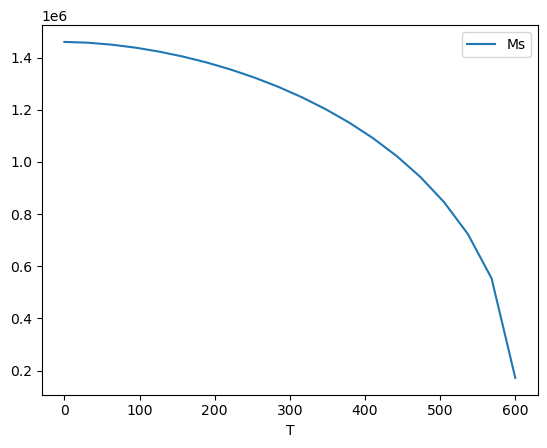

In [11]:
results_spindynamics.dataframe.plot(x="T");

## 3: Calculate micromagnetic intrinsic properties using Kuz'min formula

In [12]:
kuzmin_result = mammos_analysis.kuzmin_properties(
    T=results_spindynamics.T,
    Ms=results_spindynamics.Ms,
    K1_0=results_dft.K1_0,
)

In [13]:
kuzmin_result

KuzminResult(Ms=Ms(T), A=A(T), K1=K1(T))

In [14]:
temperature = me.Entity("ThermodynamicTemperature", value=300, unit="K")
temperature

ThermodynamicTemperature(value=300.0, unit=K)

In [15]:
kuzmin_result.Ms(temperature), kuzmin_result.A(temperature), kuzmin_result.K1(temperature) 

(SpontaneousMagnetization(value=1259264.6948937078, unit=A / m),
 ExchangeStiffnessConstant(value=4.158634560339533e-12, unit=J / m),
 UniaxialAnisotropyConstant(value=2759058.8934449223, unit=J / m3))

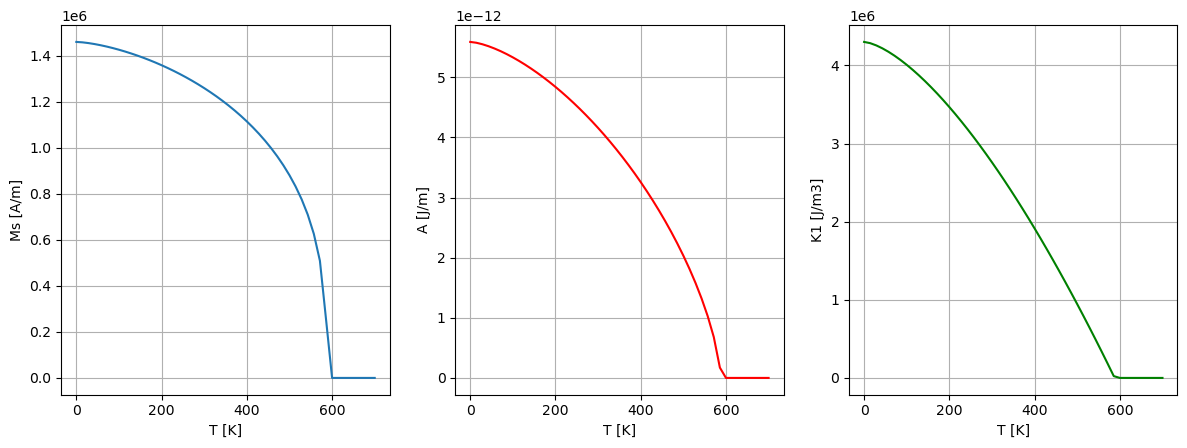

In [16]:
temprature_range = np.linspace(0, 700, 50)

w, h = figaspect(1/3)
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(w, h))
ax[0].plot(temprature_range, kuzmin_result.Ms(temprature_range))
ax[0].set_xlabel("T [K]")
ax[0].set_ylabel("Ms [A/m]")
ax[0].grid()

ax[1].plot(temprature_range, kuzmin_result.A(temprature_range), c="r")
ax[1].set_xlabel("T [K]")
ax[1].set_ylabel("A [J/m]")
ax[1].grid()

ax[2].plot(temprature_range, kuzmin_result.K1(temprature_range), c="g")
ax[2].set_xlabel("T [K]")
ax[2].set_ylabel("K1 [J/m3]")
ax[2].grid(2)

plt.show()

## 4: Run micromagnetic simulation - Evaluate hysteresis loop

In [17]:
loop_results = mammos_mumag.hysteresis.run(
    mesh_filepath=mammos_mumag.mesh.CUBE_20_nm,
    Ms=kuzmin_result.Ms(temperature),
    A=kuzmin_result.A(temperature),
    K1=kuzmin_result.K1(temperature),
    hstart=(7*u.T).to(u.A / u.m),
    hfinal=(-10*u.T).to(u.A / u.m),
    hnsteps=30,
)

In [18]:
loop_results.H

ExternalMagneticField(value=[ 5570423.00518393  5119484.00000238  4668544.99482082  4217605.98963926
  3766666.98445771  3315727.97927615  2864788.9740946   2413849.96891304
  1962910.96373148  1511971.95854993  1061032.95336837   610093.94818681
   159154.94300526  -291784.0621763   -742723.06735786 -1193662.07253941
 -1644601.07772097 -2095540.08290253 -2546479.08808408 -2997418.09326564], unit=A / m)

In [19]:
loop_results.M

SpontaneousMagnetization(value=[ 1259072.54948691  1259052.82405814  1259029.88979995  1259003.00951274
  1258971.22082684  1258933.24832515  1258887.37253304  1258831.23005096
  1258761.49986522  1258673.39503945  1258559.80771436  1258409.80693522
  1258205.8557006   1257918.33169754  1257493.74506011  1256826.88566053
  1255684.14964086  1253440.55163873  1247685.52503722 -1258901.81208836], unit=A / m)

In [20]:
loop_results.energy_density

EnergyDensity(value=[-11263295.7968233  -10549826.8036711   -9836369.86693898
  -9122927.00480267  -8409500.71360256  -7696094.11871081
  -6982711.18652129  -6269357.02860965  -5556038.34863155
  -4842764.11703525  -4129546.62228756  -3416403.17028038
  -2703358.95502889  -1990452.17392082  -1277743.76972748
   -565337.64884521    146572.15808322    857570.66580037
   1566526.87122784  -7192526.96371776], unit=J / m3)

The `dataframe` property generates a dataframe in the SI units.

In [21]:
loop_results.dataframe.head()

,configuration_type,H,M,energy_density
0,1,5.570423e+06,1.259073e+06,-1.126330e+07
1,1,5.119484e+06,1.259053e+06,-1.054983e+07
2,1,4.668545e+06,1.259030e+06,-9.836370e+06
3,1,4.217606e+06,1.259003e+06,-9.122927e+06
4,1,3.766667e+06,1.258971e+06,-8.409501e+06


We can generate a table in alternate unites:

In [22]:
df = pd.DataFrame(
    {
        "mu0_H": loop_results.H.to(u.T),
        "J": loop_results.M.to(u.T),
    }
)
df.head()

,mu0_H,J
0,7.000000,1.582197
1,6.433333,1.582172
2,5.866667,1.582144
3,5.300000,1.582110
4,4.733333,1.582070


In [23]:
# INFO: useful information
# df["H"] = (df["mu0_Hext"].to_numpy() * u.T).to("A/m")
# df["M"] = (df["polarisation"].to_numpy() * u.T).to("A/m").value
(df * u.T.to("A/m")).head()

,mu0_H,J
0,5.570423e+06,1.259073e+06
1,5.119484e+06,1.259053e+06
2,4.668545e+06,1.259030e+06
3,4.217606e+06,1.259003e+06
4,3.766667e+06,1.258971e+06


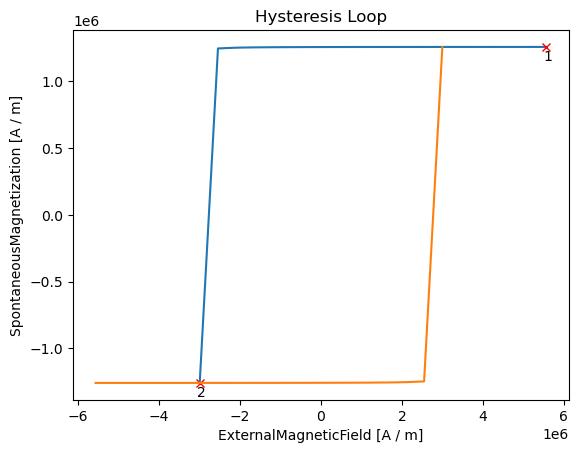

In [24]:
loop_results.plot(duplicate=True, configuration_marks=True)

In [25]:
loop_results.configurations

{1: PosixPath('/home/swapneel/Projects/MaMMoS/mammos/docs/source/examples/workflows/hystloop/hystloop_0001.vtu'),
 2: PosixPath('/home/swapneel/Projects/MaMMoS/mammos/docs/source/examples/workflows/hystloop/hystloop_0002.vtu')}

In [26]:
loop_results.plot_configuration(1, jupyter_backend="trame")

Widget(value='<iframe src="http://localhost:37403/index.html?ui=P_0x79cc465e9b90_0&reconnect=auto" class="pyvi…

We can extract the extrinsic properties with the `extrinsic_properties` function from the `mammos_analysis` package:

In [27]:
extrinsic_properties = mammos_analysis.hysteresis.extrinsic_properties(
    loop_results.M,
    loop_results.H,
    demagnetisation_coefficient=None,
)

In [28]:
extrinsic_properties.Hc

CoercivityHcExternal(value=1258104.3766406984, unit=A / m)

In [29]:
extrinsic_properties.Mr

Remanence(value=2770939.67683217, unit=A / m)

In [30]:
extrinsic_properties.BHmax
# is Not A Number (not yet implemented).

MaximumEnergyProduct(value=nan, unit=J / m3)

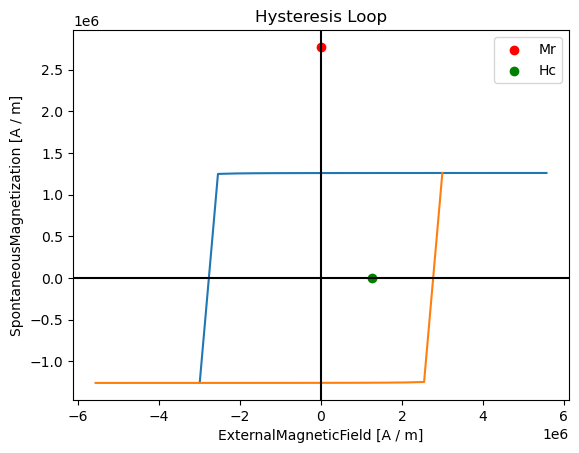

In [31]:
loop_results.plot()
plt.axhline(0, c="k")
plt.axvline(0, c="k")
plt.scatter([0],[extrinsic_properties.Mr.value], c="r", label="Mr")
plt.scatter(extrinsic_properties.Hc.value, 0, c="g", label="Hc")
plt.legend();